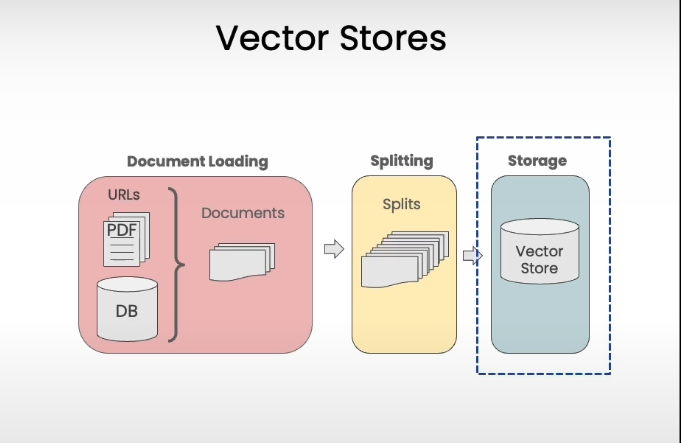

# Vectorstores and Embeddings

Recall the overall workflow for retrieval augmented generation (RAG):

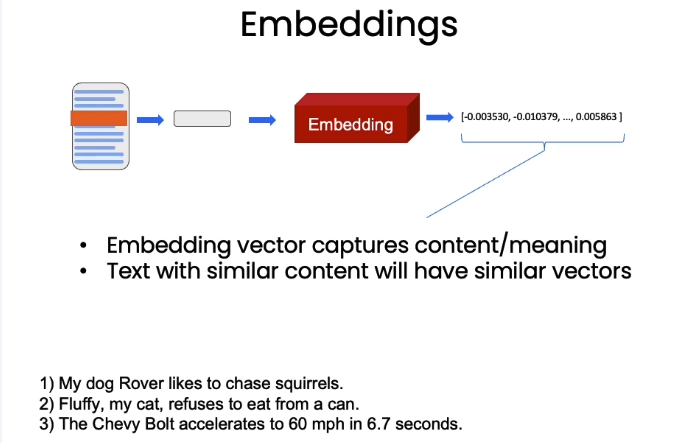

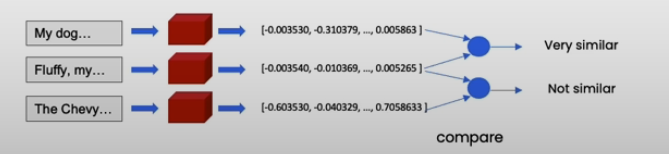

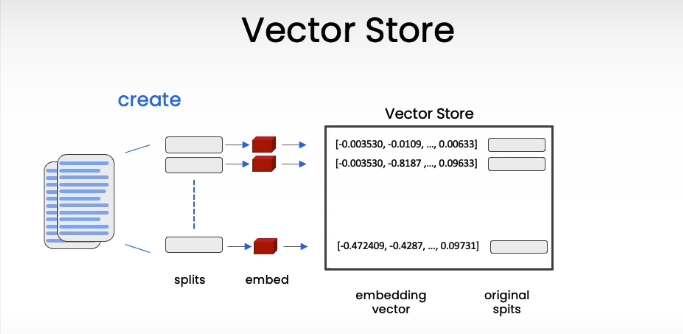

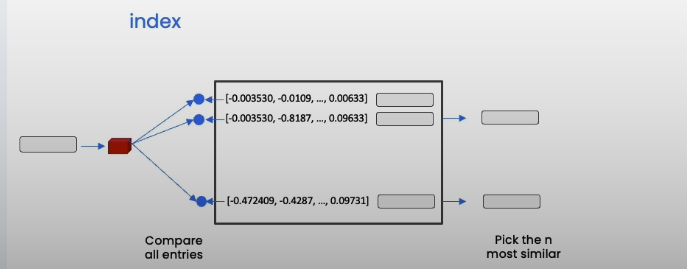

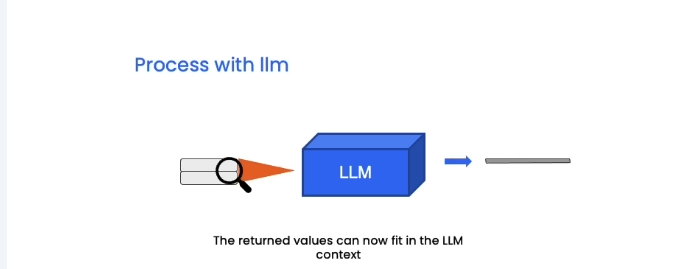

In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Chroma

In [2]:
# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("Data/MachineLearning-Lecture01 (Copy).pdf"),
    PyPDFLoader("Data/DeepSeek_R1.pdf"),
    PyPDFLoader("Data/Kolmogorov–Arnold Transformer.pdf"),
    PyPDFLoader("Data/MachineLearning-Lecture01.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [3]:
docs[0]

Document(metadata={'source': 'Data/MachineLearning-Lecture01 (Copy).pdf', 'page': 0}, page_content='MachineLearning-Lecture01  \nInstructor (Andrew Ng): Okay. Good morning. Welcome to CS229, the machine \nlearning class. So what I wanna do today is just spend a little time going over the logistics \nof the class, and then we\'ll start to talk a bit about machine learning.  \nBy way of introduction, my name\'s Andrew Ng and I\'ll be instructor for this class. And so \nI personally work in machine learning, and I\'ve worked on it for about 15 years now, and \nI actually think that machine learning is the most exciting field of all the computer \nsciences. So I\'m actually always excited about teaching this class. Sometimes I actually \nthink that machine learning is not only the most exciting thing in computer science, but \nthe most exciting thing in all of human endeavor, so maybe a little bias there.  \nI also want to introduce the TAs, who are all graduate students doing research in 

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [5]:
splits = text_splitter.split_documents(docs)

In [7]:
len(splits)

219

## Embeddings

Let's take our splits and embed them.

In [8]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings= HuggingFaceEmbeddings(model_name = model_name)

/tmp/ipykernel_106305/2774317636.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings= HuggingFaceEmbeddings(model_name = model_name)
2025-03-23 02:28:21.780543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742675302.011549  106305 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742675302.066760  106305 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugi

In [9]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [10]:
embededding_1 = embeddings.embed_query(sentence1)
embededding_2 = embeddings.embed_query(sentence2)
embededding_3 = embeddings.embed_query(sentence3)

In [11]:
import numpy as np

In [12]:
np.dot(embededding_1, embededding_2)

0.9151646360594947

In [13]:
np.dot(embededding_1, embededding_3)

0.08337090111946241

In [14]:
np.dot(embededding_2, embededding_3)

0.04040366845742266

## Vectorstores

In [15]:
persist_directory = 'docs/chroma/'

In [24]:
!rm -rf ./docs/chroma  # remove old database files if any

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Faiss Vector Store

In [27]:
index_path = "faiss_index"
vector_store = FAISS.from_documents(
    splits,
    embeddings
)
vector_store.save_local(index_path)

In [17]:
index_path = "faiss_index"
local_vector_store = FAISS.load_local(
            folder_path=index_path,
            embeddings=embeddings,
            allow_dangerous_deserialization=True
        )

In [18]:
docs = local_vector_store.as_retriever(search_type = "similarity", search_kwargs={"k": 3})

In [21]:
results = local_vector_store.similarity_search(
    "Deepseek R1",
    k=3,
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* performance of DeepSeek-R1 will improve in the next version, as the amount of related RL
training data currently remains very limited.
3.2. Distilled Model Evaluation
Model AIME 2024 MATH-500 GPQA LiveCode CodeForcesDiamond Bench
pass@1 cons@64 pass@1 pass@1 pass@1 rating
GPT-4o-0513 9.3 13.4 74.6 49.9 32.9 759
Claude-3.5-Sonnet-1022 16.0 26.7 78.3 65.0 38.9 717
OpenAI-o1-mini 63.6 80.0 90.0 60.0 53.8 1820
QwQ-32B-Preview 50.0 60.0 90.6 54.5 41.9 1316
DeepSeek-R1-Distill-Qwen-1.5B28.9 52.7 83.9 33.8 16.9 954
DeepSeek-R1-Distill-Qwen-7B 55.5 83.3 92.8 49.1 37.6 1189
DeepSeek-R1-Distill-Qwen-14B69.7 80.0 93.9 59.1 53.1 1481
DeepSeek-R1-Distill-Qwen-32B 72.6 83.3 94.3 62.1 57.2 1691
DeepSeek-R1-Distill-Llama-8B 50.4 80.0 89.1 49.0 39.6 1205
DeepSeek-R1-Distill-Llama-70B70.0 86.7 94.5 65.2 57.5 1633
Table 5 |Comparison of DeepSeek-R1 distilled models and other comparable models on
reasoning-related benchmarks.
As shown in Table 5, simply distilling DeepSeek-R1’s outputs enables the effic

### Chroma Vector Store

In [25]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)

In [26]:
print(vectordb._collection.count())

219


In [33]:
question = "DeepSeek R1"
results = vectordb.similarity_search(
    question,
    k=3
)

In [34]:
results[0].page_content

'performance of DeepSeek-R1 will improve in the next version, as the amount of related RL\ntraining data currently remains very limited.\n3.2. Distilled Model Evaluation\nModel AIME 2024 MATH-500 GPQA LiveCode CodeForcesDiamond Bench\npass@1 cons@64 pass@1 pass@1 pass@1 rating\nGPT-4o-0513 9.3 13.4 74.6 49.9 32.9 759\nClaude-3.5-Sonnet-1022 16.0 26.7 78.3 65.0 38.9 717\nOpenAI-o1-mini 63.6 80.0 90.0 60.0 53.8 1820\nQwQ-32B-Preview 50.0 60.0 90.6 54.5 41.9 1316\nDeepSeek-R1-Distill-Qwen-1.5B28.9 52.7 83.9 33.8 16.9 954\nDeepSeek-R1-Distill-Qwen-7B 55.5 83.3 92.8 49.1 37.6 1189\nDeepSeek-R1-Distill-Qwen-14B69.7 80.0 93.9 59.1 53.1 1481\nDeepSeek-R1-Distill-Qwen-32B 72.6 83.3 94.3 62.1 57.2 1691\nDeepSeek-R1-Distill-Llama-8B 50.4 80.0 89.1 49.0 39.6 1205\nDeepSeek-R1-Distill-Llama-70B70.0 86.7 94.5 65.2 57.5 1633\nTable 5 |Comparison of DeepSeek-R1 distilled models and other comparable models on\nreasoning-related benchmarks.\nAs shown in Table 5, simply distilling DeepSeek-R1’s outputs e

In [35]:
vectordb.persist()

/tmp/ipykernel_208690/3711397106.py:1: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()
